# All image csv files

In [1]:
import os
import csv

def create_csv(image_folder, csv_file_path):
    # CSV header
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object and write the header
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for filename in sorted(os.listdir(image_folder)):
            # complete image file path
            image_path = os.path.join(image_folder, filename)

            # filename to extract HospitalID, PatientID, image number, and image label
            parts = filename.split('_')
            hospital_id = parts[3]
            patient_id = parts[1]
            image_number = parts[6]
            image_label = parts[4]

            # write data into the CSV file
            writer.writerow({
                'HospitalID': hospital_id,
                'PatientID': patient_id,
                'ImageID': image_number,
                'ImagePath': image_path,
                'Label': image_label
            })

    # created and saved
    print("CSV file has been created and saved to:", csv_file_path)


image_folder = "/local/data1/honzh073/data/8bit_down224"
csv_file_path = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"
create_csv(image_folder, csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv


In [1]:
# Custom dataset class
import os
import csv
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn.functional as F

# custom dataset on csv files
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.hospital_ids = []  # Store hospital IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']
                hospital_id = row['HospitalID']

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)
                self.hospital_ids.append(int(hospital_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model = model.to(device)

    model.eval()

    correct_test_nff = 0
    correct_test_aff = 0
    total_nff = 0
    total_aff = 0
    total_test = 0
    test_loss = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            total_nff += (labels == 0).sum().item()
            total_aff += (labels == 1).sum().item()
            correct_test_nff += ((predicted == labels) & (labels == 0)).sum().item()
            correct_test_aff += ((predicted == labels) & (labels == 1)).sum().item()
            test_loss += loss.item()

    # Check if total_aff is zero before performing the division
    test_accuracy_nff = 100 * (correct_test_nff / total_nff) if total_nff != 0 else 0
    test_accuracy_aff = 100 * (correct_test_aff / total_aff) if total_aff != 0 else 0
    test_accuracy_total = 100 * (correct_test_nff + correct_test_aff) / total_test
    test_loss /= len(test_loader)

    # Handle the case where there is only one class
    if len(set(all_labels)) > 1:
        auc_score = roc_auc_score(all_labels, all_predictions)
    else:
        auc_score = 0  # Default value if only one class is present

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Directly use class labels as strings in target_names
    target_names = ['NFF', 'AFF']

    classification_rep = classification_report(all_labels, all_predictions, target_names=target_names, labels=[0, 1], zero_division=1)

    # Store metrics in a dictionary
    metrics = {
        "Test Loss": test_loss,
        "Total Test Accuracy": test_accuracy_total,
        "Test Accuracy (NFF)": test_accuracy_nff,
        "Test Accuracy (AFF)": test_accuracy_aff,
        "AUC": auc_score,
        "Confusion Matrix": conf_matrix,
        "Classification Report": classification_rep
    }
    return metrics


# VGG 19


Performance for Hospital 1:

Test Loss: 0.1904100924730301
Total Test Accuracy: 95.65217391304348
Test Accuracy (NFF): 95.65217391304348
Test Accuracy (AFF): 0
Confusion Matrix:
 [[22  1]
 [ 0  0]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      0.96      0.98        23
         AFF       0.00      1.00      0.00         0

    accuracy                           0.96        23
   macro avg       0.50      0.98      0.49        23
weighted avg       1.00      0.96      0.98        23


Performance for Hospital 2:

Test Loss: 0.06496712565422058
Total Test Accuracy: 100.0
Test Accuracy (NFF): 0
Test Accuracy (AFF): 100.0
Confusion Matrix:
 [[3]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      1.00      1.00         0
         AFF       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00         3
   macro avg       1.00      1.00      1.00  

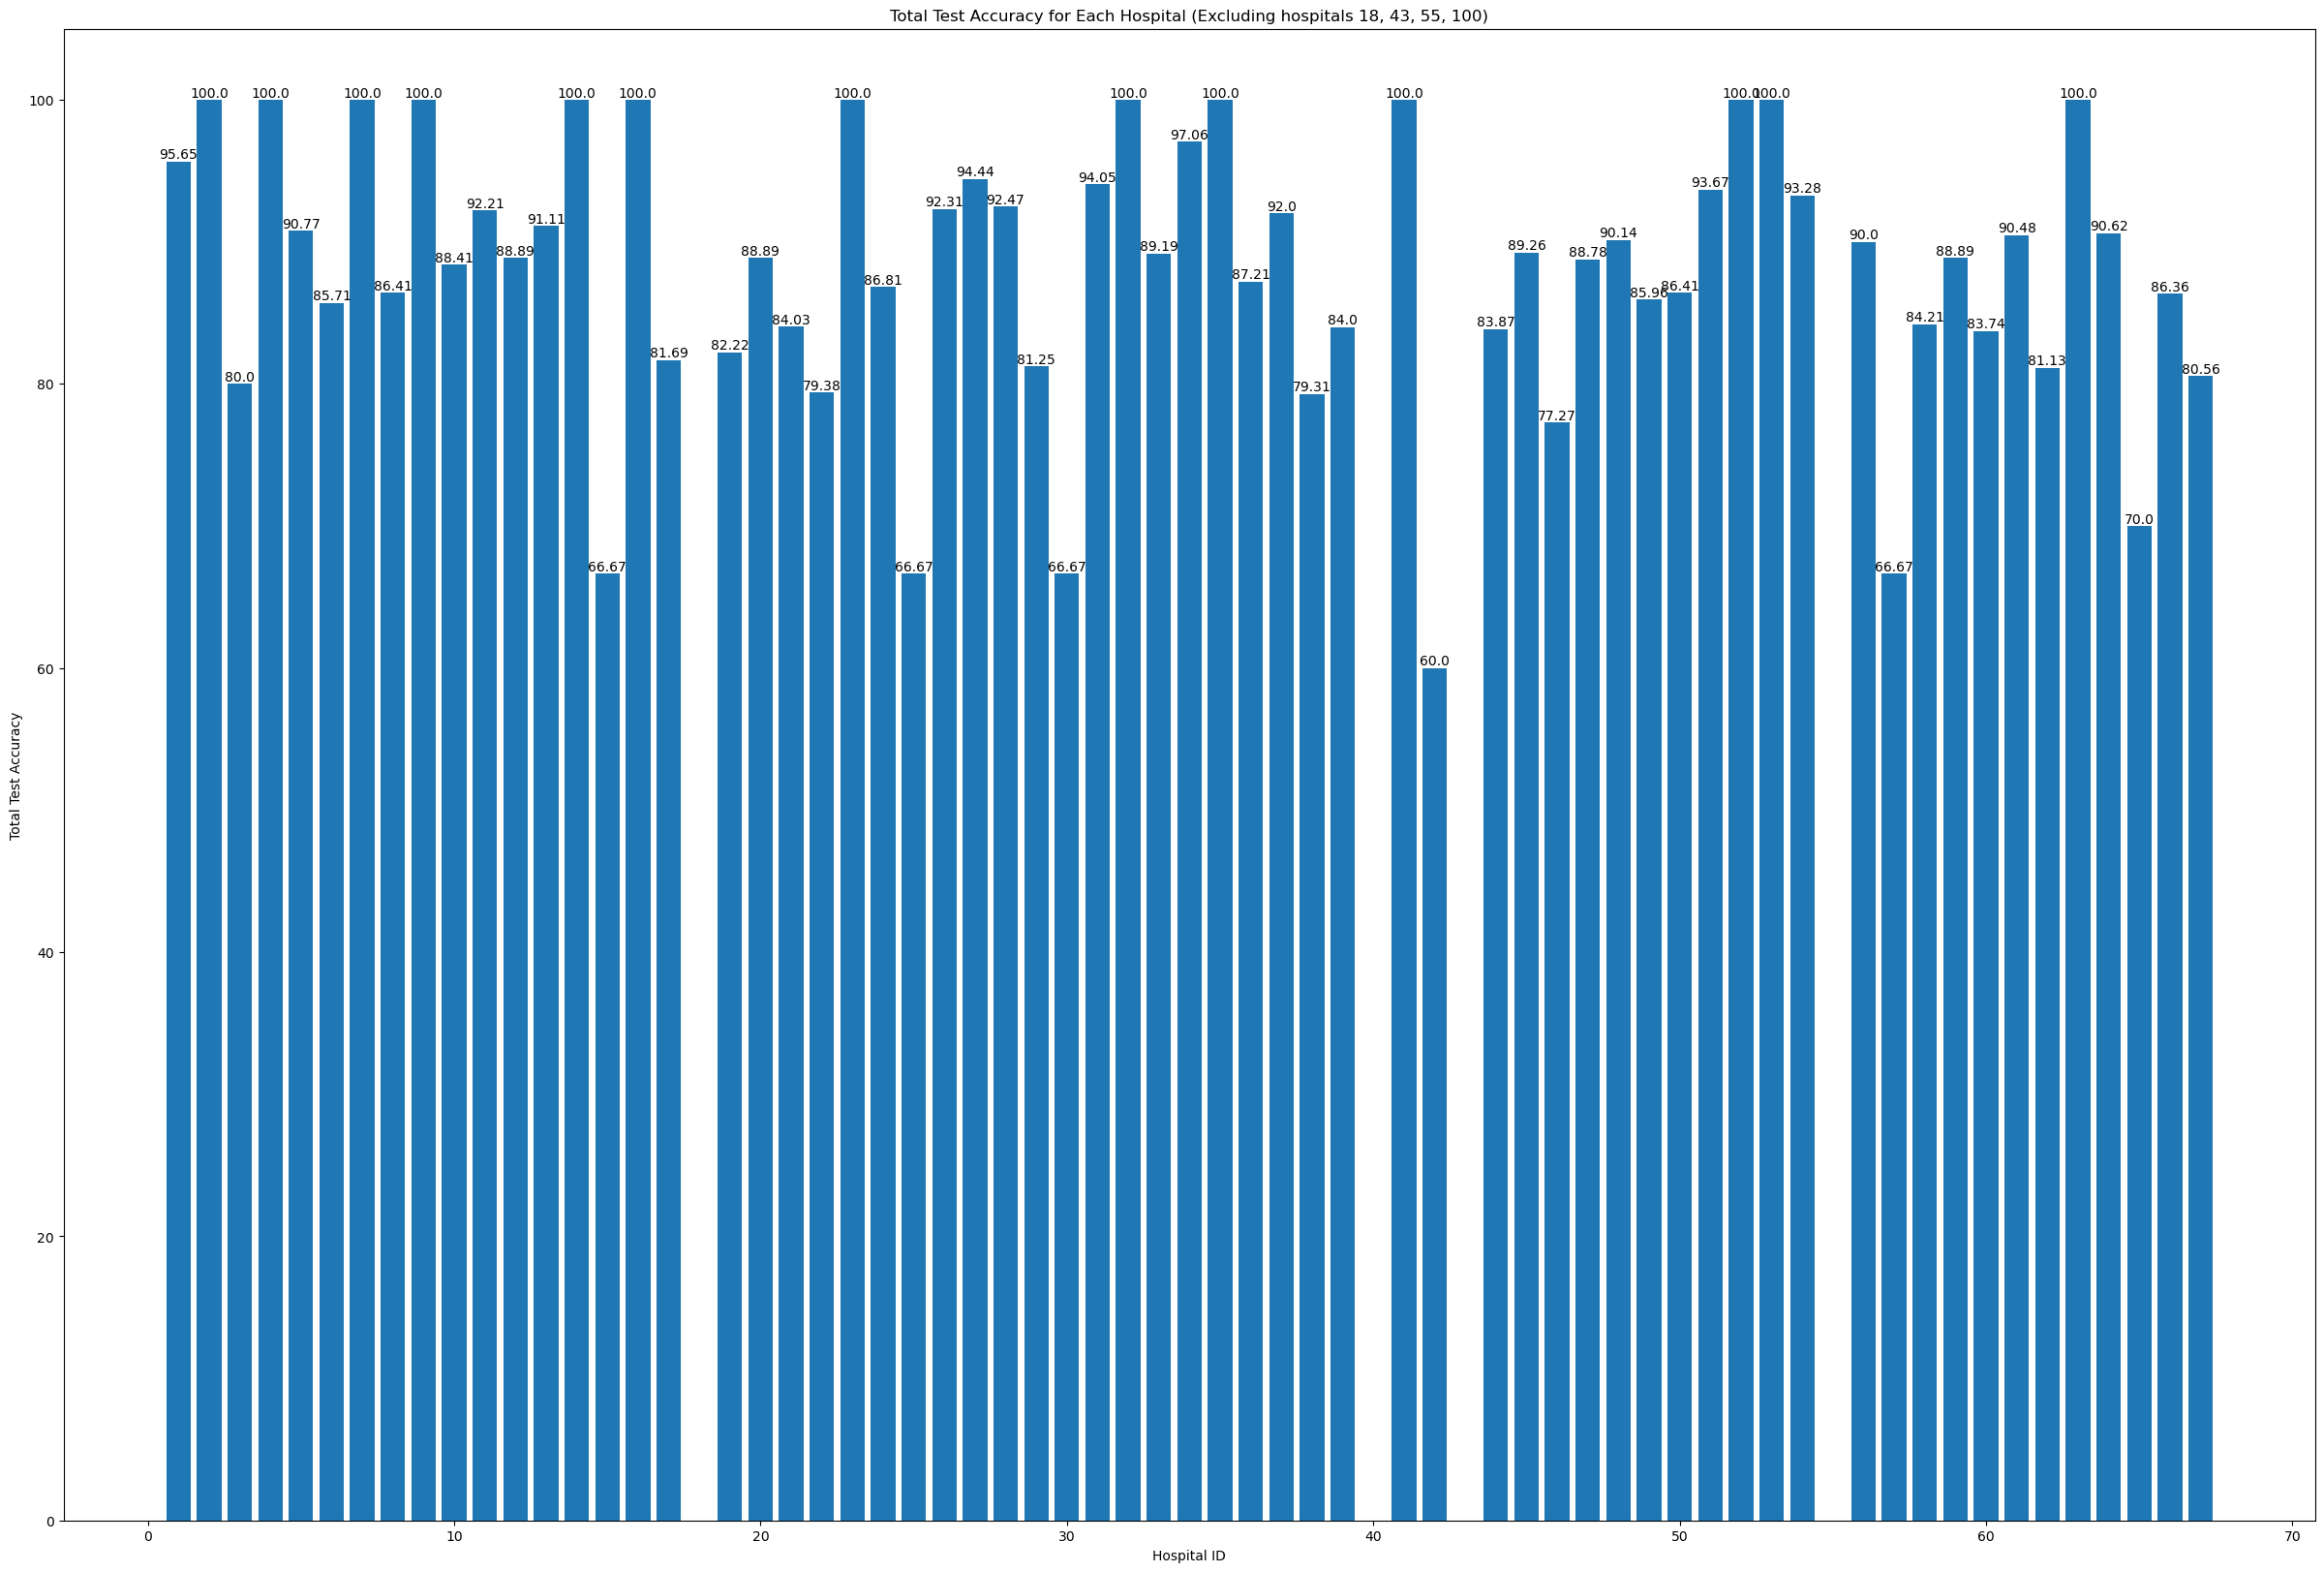

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import vgg19, VGG19_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# models from job, 50% freezed
class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        # Load the pre-trained VGG19 model
        vgg19_model = models.vgg19(weights=VGG19_Weights.DEFAULT)

        # Extract features (all layers except the classifier)
        self.features = nn.Sequential(*list(vgg19_model.features.children()))

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:])

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        in_features = vgg19_model.classifier[0].in_features
        self.classifier = nn.Linear(in_features, num_classes)  # VGG19's last feature map has 512 channels

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# vgg19_freeze_Adam_100R_2E
global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/8851362f-e38d-4f9b-91b6-2cb42da00d67/app_server/FL_global_model.pt'
checkpoint = torch.load(global_path, map_location=device)

# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()


# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(30, 20))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()

# ResNet 50



Performance for Hospital 1:

Test Loss: nan
Total Test Accuracy: 100.0
Test Accuracy (NFF): 100.0
Test Accuracy (AFF): 0
Confusion Matrix:
 [[23]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      1.00      1.00        23
         AFF       1.00      1.00      1.00         0

   micro avg       1.00      1.00      1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23


Performance for Hospital 2:

Test Loss: nan
Total Test Accuracy: 0.0
Test Accuracy (NFF): 0
Test Accuracy (AFF): 0.0
Confusion Matrix:
 [[0 0]
 [3 0]]
Classification Report:
               precision    recall  f1-score   support

         NFF       0.00      1.00      0.00       0.0
         AFF       1.00      0.00      0.00       3.0

    accuracy                           1.00       3.0
   macro avg       0.50      0.50      0.00       3.0
weighted avg       1.00      0.00      0.00       3.0

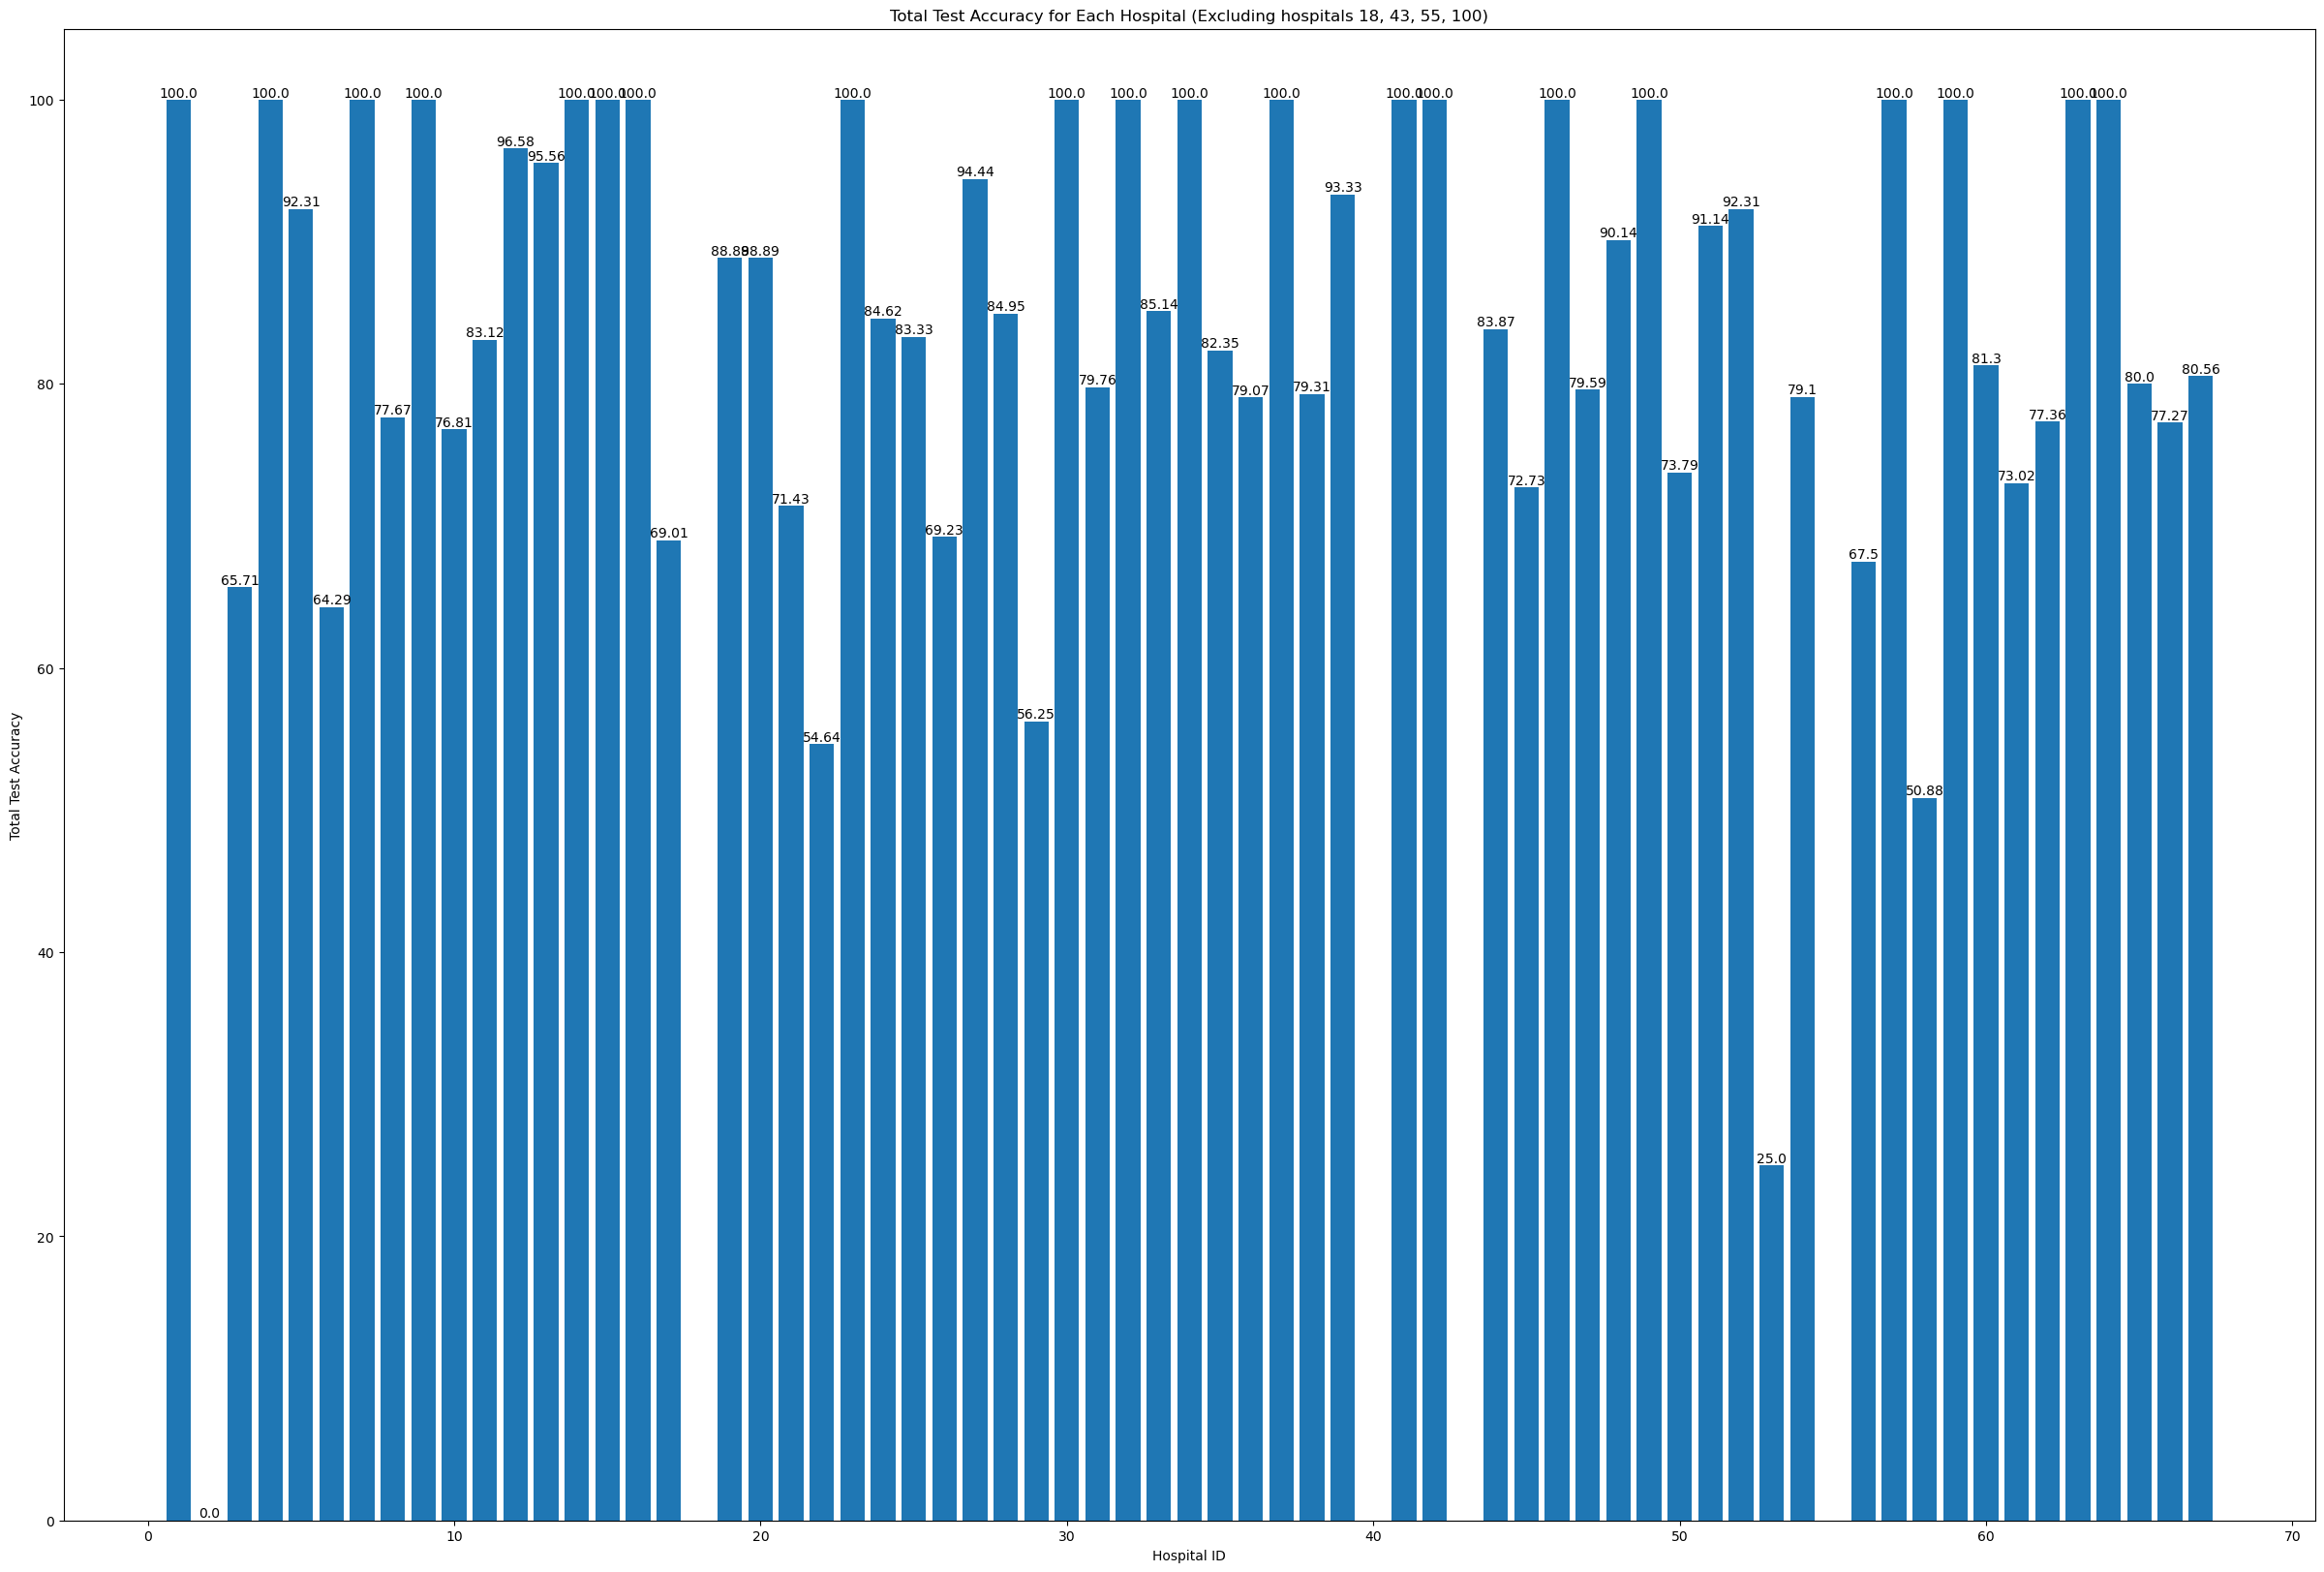

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        self.features = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Calculate the index where to split the layerszh
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/fb262ec6-2dbc-4795-84ab-1829c168142d/app_server/FL_global_model.pt'
global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/bac7e29b-845d-4ebe-b686-6cc7da2c27a8/app_server/FL_global_model.pt'
checkpoint = torch.load(global_path, map_location=device)

# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()

# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(30, 20))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()

# ResNet 101

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        self.features = models.resnet101(weights=ResNet101_Weights.DEFAULT)

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/f27f16fb-aded-4fe1-b2b7-0ec3d40e97b7/app_server/FL_global_model.pt'


checkpoint = torch.load(global_path, map_location=device)

# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()

# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(30, 20))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()

RuntimeError: Error(s) in loading state_dict for CustomNet:
	Missing key(s) in state_dict: "features.layer3.6.conv1.weight", "features.layer3.6.bn1.weight", "features.layer3.6.bn1.bias", "features.layer3.6.bn1.running_mean", "features.layer3.6.bn1.running_var", "features.layer3.6.conv2.weight", "features.layer3.6.bn2.weight", "features.layer3.6.bn2.bias", "features.layer3.6.bn2.running_mean", "features.layer3.6.bn2.running_var", "features.layer3.6.conv3.weight", "features.layer3.6.bn3.weight", "features.layer3.6.bn3.bias", "features.layer3.6.bn3.running_mean", "features.layer3.6.bn3.running_var", "features.layer3.7.conv1.weight", "features.layer3.7.bn1.weight", "features.layer3.7.bn1.bias", "features.layer3.7.bn1.running_mean", "features.layer3.7.bn1.running_var", "features.layer3.7.conv2.weight", "features.layer3.7.bn2.weight", "features.layer3.7.bn2.bias", "features.layer3.7.bn2.running_mean", "features.layer3.7.bn2.running_var", "features.layer3.7.conv3.weight", "features.layer3.7.bn3.weight", "features.layer3.7.bn3.bias", "features.layer3.7.bn3.running_mean", "features.layer3.7.bn3.running_var", "features.layer3.8.conv1.weight", "features.layer3.8.bn1.weight", "features.layer3.8.bn1.bias", "features.layer3.8.bn1.running_mean", "features.layer3.8.bn1.running_var", "features.layer3.8.conv2.weight", "features.layer3.8.bn2.weight", "features.layer3.8.bn2.bias", "features.layer3.8.bn2.running_mean", "features.layer3.8.bn2.running_var", "features.layer3.8.conv3.weight", "features.layer3.8.bn3.weight", "features.layer3.8.bn3.bias", "features.layer3.8.bn3.running_mean", "features.layer3.8.bn3.running_var", "features.layer3.9.conv1.weight", "features.layer3.9.bn1.weight", "features.layer3.9.bn1.bias", "features.layer3.9.bn1.running_mean", "features.layer3.9.bn1.running_var", "features.layer3.9.conv2.weight", "features.layer3.9.bn2.weight", "features.layer3.9.bn2.bias", "features.layer3.9.bn2.running_mean", "features.layer3.9.bn2.running_var", "features.layer3.9.conv3.weight", "features.layer3.9.bn3.weight", "features.layer3.9.bn3.bias", "features.layer3.9.bn3.running_mean", "features.layer3.9.bn3.running_var", "features.layer3.10.conv1.weight", "features.layer3.10.bn1.weight", "features.layer3.10.bn1.bias", "features.layer3.10.bn1.running_mean", "features.layer3.10.bn1.running_var", "features.layer3.10.conv2.weight", "features.layer3.10.bn2.weight", "features.layer3.10.bn2.bias", "features.layer3.10.bn2.running_mean", "features.layer3.10.bn2.running_var", "features.layer3.10.conv3.weight", "features.layer3.10.bn3.weight", "features.layer3.10.bn3.bias", "features.layer3.10.bn3.running_mean", "features.layer3.10.bn3.running_var", "features.layer3.11.conv1.weight", "features.layer3.11.bn1.weight", "features.layer3.11.bn1.bias", "features.layer3.11.bn1.running_mean", "features.layer3.11.bn1.running_var", "features.layer3.11.conv2.weight", "features.layer3.11.bn2.weight", "features.layer3.11.bn2.bias", "features.layer3.11.bn2.running_mean", "features.layer3.11.bn2.running_var", "features.layer3.11.conv3.weight", "features.layer3.11.bn3.weight", "features.layer3.11.bn3.bias", "features.layer3.11.bn3.running_mean", "features.layer3.11.bn3.running_var", "features.layer3.12.conv1.weight", "features.layer3.12.bn1.weight", "features.layer3.12.bn1.bias", "features.layer3.12.bn1.running_mean", "features.layer3.12.bn1.running_var", "features.layer3.12.conv2.weight", "features.layer3.12.bn2.weight", "features.layer3.12.bn2.bias", "features.layer3.12.bn2.running_mean", "features.layer3.12.bn2.running_var", "features.layer3.12.conv3.weight", "features.layer3.12.bn3.weight", "features.layer3.12.bn3.bias", "features.layer3.12.bn3.running_mean", "features.layer3.12.bn3.running_var", "features.layer3.13.conv1.weight", "features.layer3.13.bn1.weight", "features.layer3.13.bn1.bias", "features.layer3.13.bn1.running_mean", "features.layer3.13.bn1.running_var", "features.layer3.13.conv2.weight", "features.layer3.13.bn2.weight", "features.layer3.13.bn2.bias", "features.layer3.13.bn2.running_mean", "features.layer3.13.bn2.running_var", "features.layer3.13.conv3.weight", "features.layer3.13.bn3.weight", "features.layer3.13.bn3.bias", "features.layer3.13.bn3.running_mean", "features.layer3.13.bn3.running_var", "features.layer3.14.conv1.weight", "features.layer3.14.bn1.weight", "features.layer3.14.bn1.bias", "features.layer3.14.bn1.running_mean", "features.layer3.14.bn1.running_var", "features.layer3.14.conv2.weight", "features.layer3.14.bn2.weight", "features.layer3.14.bn2.bias", "features.layer3.14.bn2.running_mean", "features.layer3.14.bn2.running_var", "features.layer3.14.conv3.weight", "features.layer3.14.bn3.weight", "features.layer3.14.bn3.bias", "features.layer3.14.bn3.running_mean", "features.layer3.14.bn3.running_var", "features.layer3.15.conv1.weight", "features.layer3.15.bn1.weight", "features.layer3.15.bn1.bias", "features.layer3.15.bn1.running_mean", "features.layer3.15.bn1.running_var", "features.layer3.15.conv2.weight", "features.layer3.15.bn2.weight", "features.layer3.15.bn2.bias", "features.layer3.15.bn2.running_mean", "features.layer3.15.bn2.running_var", "features.layer3.15.conv3.weight", "features.layer3.15.bn3.weight", "features.layer3.15.bn3.bias", "features.layer3.15.bn3.running_mean", "features.layer3.15.bn3.running_var", "features.layer3.16.conv1.weight", "features.layer3.16.bn1.weight", "features.layer3.16.bn1.bias", "features.layer3.16.bn1.running_mean", "features.layer3.16.bn1.running_var", "features.layer3.16.conv2.weight", "features.layer3.16.bn2.weight", "features.layer3.16.bn2.bias", "features.layer3.16.bn2.running_mean", "features.layer3.16.bn2.running_var", "features.layer3.16.conv3.weight", "features.layer3.16.bn3.weight", "features.layer3.16.bn3.bias", "features.layer3.16.bn3.running_mean", "features.layer3.16.bn3.running_var", "features.layer3.17.conv1.weight", "features.layer3.17.bn1.weight", "features.layer3.17.bn1.bias", "features.layer3.17.bn1.running_mean", "features.layer3.17.bn1.running_var", "features.layer3.17.conv2.weight", "features.layer3.17.bn2.weight", "features.layer3.17.bn2.bias", "features.layer3.17.bn2.running_mean", "features.layer3.17.bn2.running_var", "features.layer3.17.conv3.weight", "features.layer3.17.bn3.weight", "features.layer3.17.bn3.bias", "features.layer3.17.bn3.running_mean", "features.layer3.17.bn3.running_var", "features.layer3.18.conv1.weight", "features.layer3.18.bn1.weight", "features.layer3.18.bn1.bias", "features.layer3.18.bn1.running_mean", "features.layer3.18.bn1.running_var", "features.layer3.18.conv2.weight", "features.layer3.18.bn2.weight", "features.layer3.18.bn2.bias", "features.layer3.18.bn2.running_mean", "features.layer3.18.bn2.running_var", "features.layer3.18.conv3.weight", "features.layer3.18.bn3.weight", "features.layer3.18.bn3.bias", "features.layer3.18.bn3.running_mean", "features.layer3.18.bn3.running_var", "features.layer3.19.conv1.weight", "features.layer3.19.bn1.weight", "features.layer3.19.bn1.bias", "features.layer3.19.bn1.running_mean", "features.layer3.19.bn1.running_var", "features.layer3.19.conv2.weight", "features.layer3.19.bn2.weight", "features.layer3.19.bn2.bias", "features.layer3.19.bn2.running_mean", "features.layer3.19.bn2.running_var", "features.layer3.19.conv3.weight", "features.layer3.19.bn3.weight", "features.layer3.19.bn3.bias", "features.layer3.19.bn3.running_mean", "features.layer3.19.bn3.running_var", "features.layer3.20.conv1.weight", "features.layer3.20.bn1.weight", "features.layer3.20.bn1.bias", "features.layer3.20.bn1.running_mean", "features.layer3.20.bn1.running_var", "features.layer3.20.conv2.weight", "features.layer3.20.bn2.weight", "features.layer3.20.bn2.bias", "features.layer3.20.bn2.running_mean", "features.layer3.20.bn2.running_var", "features.layer3.20.conv3.weight", "features.layer3.20.bn3.weight", "features.layer3.20.bn3.bias", "features.layer3.20.bn3.running_mean", "features.layer3.20.bn3.running_var", "features.layer3.21.conv1.weight", "features.layer3.21.bn1.weight", "features.layer3.21.bn1.bias", "features.layer3.21.bn1.running_mean", "features.layer3.21.bn1.running_var", "features.layer3.21.conv2.weight", "features.layer3.21.bn2.weight", "features.layer3.21.bn2.bias", "features.layer3.21.bn2.running_mean", "features.layer3.21.bn2.running_var", "features.layer3.21.conv3.weight", "features.layer3.21.bn3.weight", "features.layer3.21.bn3.bias", "features.layer3.21.bn3.running_mean", "features.layer3.21.bn3.running_var", "features.layer3.22.conv1.weight", "features.layer3.22.bn1.weight", "features.layer3.22.bn1.bias", "features.layer3.22.bn1.running_mean", "features.layer3.22.bn1.running_var", "features.layer3.22.conv2.weight", "features.layer3.22.bn2.weight", "features.layer3.22.bn2.bias", "features.layer3.22.bn2.running_mean", "features.layer3.22.bn2.running_var", "features.layer3.22.conv3.weight", "features.layer3.22.bn3.weight", "features.layer3.22.bn3.bias", "features.layer3.22.bn3.running_mean", "features.layer3.22.bn3.running_var", "unfrozen_features.1.6.conv1.weight", "unfrozen_features.1.6.bn1.weight", "unfrozen_features.1.6.bn1.bias", "unfrozen_features.1.6.bn1.running_mean", "unfrozen_features.1.6.bn1.running_var", "unfrozen_features.1.6.conv2.weight", "unfrozen_features.1.6.bn2.weight", "unfrozen_features.1.6.bn2.bias", "unfrozen_features.1.6.bn2.running_mean", "unfrozen_features.1.6.bn2.running_var", "unfrozen_features.1.6.conv3.weight", "unfrozen_features.1.6.bn3.weight", "unfrozen_features.1.6.bn3.bias", "unfrozen_features.1.6.bn3.running_mean", "unfrozen_features.1.6.bn3.running_var", "unfrozen_features.1.7.conv1.weight", "unfrozen_features.1.7.bn1.weight", "unfrozen_features.1.7.bn1.bias", "unfrozen_features.1.7.bn1.running_mean", "unfrozen_features.1.7.bn1.running_var", "unfrozen_features.1.7.conv2.weight", "unfrozen_features.1.7.bn2.weight", "unfrozen_features.1.7.bn2.bias", "unfrozen_features.1.7.bn2.running_mean", "unfrozen_features.1.7.bn2.running_var", "unfrozen_features.1.7.conv3.weight", "unfrozen_features.1.7.bn3.weight", "unfrozen_features.1.7.bn3.bias", "unfrozen_features.1.7.bn3.running_mean", "unfrozen_features.1.7.bn3.running_var", "unfrozen_features.1.8.conv1.weight", "unfrozen_features.1.8.bn1.weight", "unfrozen_features.1.8.bn1.bias", "unfrozen_features.1.8.bn1.running_mean", "unfrozen_features.1.8.bn1.running_var", "unfrozen_features.1.8.conv2.weight", "unfrozen_features.1.8.bn2.weight", "unfrozen_features.1.8.bn2.bias", "unfrozen_features.1.8.bn2.running_mean", "unfrozen_features.1.8.bn2.running_var", "unfrozen_features.1.8.conv3.weight", "unfrozen_features.1.8.bn3.weight", "unfrozen_features.1.8.bn3.bias", "unfrozen_features.1.8.bn3.running_mean", "unfrozen_features.1.8.bn3.running_var", "unfrozen_features.1.9.conv1.weight", "unfrozen_features.1.9.bn1.weight", "unfrozen_features.1.9.bn1.bias", "unfrozen_features.1.9.bn1.running_mean", "unfrozen_features.1.9.bn1.running_var", "unfrozen_features.1.9.conv2.weight", "unfrozen_features.1.9.bn2.weight", "unfrozen_features.1.9.bn2.bias", "unfrozen_features.1.9.bn2.running_mean", "unfrozen_features.1.9.bn2.running_var", "unfrozen_features.1.9.conv3.weight", "unfrozen_features.1.9.bn3.weight", "unfrozen_features.1.9.bn3.bias", "unfrozen_features.1.9.bn3.running_mean", "unfrozen_features.1.9.bn3.running_var", "unfrozen_features.1.10.conv1.weight", "unfrozen_features.1.10.bn1.weight", "unfrozen_features.1.10.bn1.bias", "unfrozen_features.1.10.bn1.running_mean", "unfrozen_features.1.10.bn1.running_var", "unfrozen_features.1.10.conv2.weight", "unfrozen_features.1.10.bn2.weight", "unfrozen_features.1.10.bn2.bias", "unfrozen_features.1.10.bn2.running_mean", "unfrozen_features.1.10.bn2.running_var", "unfrozen_features.1.10.conv3.weight", "unfrozen_features.1.10.bn3.weight", "unfrozen_features.1.10.bn3.bias", "unfrozen_features.1.10.bn3.running_mean", "unfrozen_features.1.10.bn3.running_var", "unfrozen_features.1.11.conv1.weight", "unfrozen_features.1.11.bn1.weight", "unfrozen_features.1.11.bn1.bias", "unfrozen_features.1.11.bn1.running_mean", "unfrozen_features.1.11.bn1.running_var", "unfrozen_features.1.11.conv2.weight", "unfrozen_features.1.11.bn2.weight", "unfrozen_features.1.11.bn2.bias", "unfrozen_features.1.11.bn2.running_mean", "unfrozen_features.1.11.bn2.running_var", "unfrozen_features.1.11.conv3.weight", "unfrozen_features.1.11.bn3.weight", "unfrozen_features.1.11.bn3.bias", "unfrozen_features.1.11.bn3.running_mean", "unfrozen_features.1.11.bn3.running_var", "unfrozen_features.1.12.conv1.weight", "unfrozen_features.1.12.bn1.weight", "unfrozen_features.1.12.bn1.bias", "unfrozen_features.1.12.bn1.running_mean", "unfrozen_features.1.12.bn1.running_var", "unfrozen_features.1.12.conv2.weight", "unfrozen_features.1.12.bn2.weight", "unfrozen_features.1.12.bn2.bias", "unfrozen_features.1.12.bn2.running_mean", "unfrozen_features.1.12.bn2.running_var", "unfrozen_features.1.12.conv3.weight", "unfrozen_features.1.12.bn3.weight", "unfrozen_features.1.12.bn3.bias", "unfrozen_features.1.12.bn3.running_mean", "unfrozen_features.1.12.bn3.running_var", "unfrozen_features.1.13.conv1.weight", "unfrozen_features.1.13.bn1.weight", "unfrozen_features.1.13.bn1.bias", "unfrozen_features.1.13.bn1.running_mean", "unfrozen_features.1.13.bn1.running_var", "unfrozen_features.1.13.conv2.weight", "unfrozen_features.1.13.bn2.weight", "unfrozen_features.1.13.bn2.bias", "unfrozen_features.1.13.bn2.running_mean", "unfrozen_features.1.13.bn2.running_var", "unfrozen_features.1.13.conv3.weight", "unfrozen_features.1.13.bn3.weight", "unfrozen_features.1.13.bn3.bias", "unfrozen_features.1.13.bn3.running_mean", "unfrozen_features.1.13.bn3.running_var", "unfrozen_features.1.14.conv1.weight", "unfrozen_features.1.14.bn1.weight", "unfrozen_features.1.14.bn1.bias", "unfrozen_features.1.14.bn1.running_mean", "unfrozen_features.1.14.bn1.running_var", "unfrozen_features.1.14.conv2.weight", "unfrozen_features.1.14.bn2.weight", "unfrozen_features.1.14.bn2.bias", "unfrozen_features.1.14.bn2.running_mean", "unfrozen_features.1.14.bn2.running_var", "unfrozen_features.1.14.conv3.weight", "unfrozen_features.1.14.bn3.weight", "unfrozen_features.1.14.bn3.bias", "unfrozen_features.1.14.bn3.running_mean", "unfrozen_features.1.14.bn3.running_var", "unfrozen_features.1.15.conv1.weight", "unfrozen_features.1.15.bn1.weight", "unfrozen_features.1.15.bn1.bias", "unfrozen_features.1.15.bn1.running_mean", "unfrozen_features.1.15.bn1.running_var", "unfrozen_features.1.15.conv2.weight", "unfrozen_features.1.15.bn2.weight", "unfrozen_features.1.15.bn2.bias", "unfrozen_features.1.15.bn2.running_mean", "unfrozen_features.1.15.bn2.running_var", "unfrozen_features.1.15.conv3.weight", "unfrozen_features.1.15.bn3.weight", "unfrozen_features.1.15.bn3.bias", "unfrozen_features.1.15.bn3.running_mean", "unfrozen_features.1.15.bn3.running_var", "unfrozen_features.1.16.conv1.weight", "unfrozen_features.1.16.bn1.weight", "unfrozen_features.1.16.bn1.bias", "unfrozen_features.1.16.bn1.running_mean", "unfrozen_features.1.16.bn1.running_var", "unfrozen_features.1.16.conv2.weight", "unfrozen_features.1.16.bn2.weight", "unfrozen_features.1.16.bn2.bias", "unfrozen_features.1.16.bn2.running_mean", "unfrozen_features.1.16.bn2.running_var", "unfrozen_features.1.16.conv3.weight", "unfrozen_features.1.16.bn3.weight", "unfrozen_features.1.16.bn3.bias", "unfrozen_features.1.16.bn3.running_mean", "unfrozen_features.1.16.bn3.running_var", "unfrozen_features.1.17.conv1.weight", "unfrozen_features.1.17.bn1.weight", "unfrozen_features.1.17.bn1.bias", "unfrozen_features.1.17.bn1.running_mean", "unfrozen_features.1.17.bn1.running_var", "unfrozen_features.1.17.conv2.weight", "unfrozen_features.1.17.bn2.weight", "unfrozen_features.1.17.bn2.bias", "unfrozen_features.1.17.bn2.running_mean", "unfrozen_features.1.17.bn2.running_var", "unfrozen_features.1.17.conv3.weight", "unfrozen_features.1.17.bn3.weight", "unfrozen_features.1.17.bn3.bias", "unfrozen_features.1.17.bn3.running_mean", "unfrozen_features.1.17.bn3.running_var", "unfrozen_features.1.18.conv1.weight", "unfrozen_features.1.18.bn1.weight", "unfrozen_features.1.18.bn1.bias", "unfrozen_features.1.18.bn1.running_mean", "unfrozen_features.1.18.bn1.running_var", "unfrozen_features.1.18.conv2.weight", "unfrozen_features.1.18.bn2.weight", "unfrozen_features.1.18.bn2.bias", "unfrozen_features.1.18.bn2.running_mean", "unfrozen_features.1.18.bn2.running_var", "unfrozen_features.1.18.conv3.weight", "unfrozen_features.1.18.bn3.weight", "unfrozen_features.1.18.bn3.bias", "unfrozen_features.1.18.bn3.running_mean", "unfrozen_features.1.18.bn3.running_var", "unfrozen_features.1.19.conv1.weight", "unfrozen_features.1.19.bn1.weight", "unfrozen_features.1.19.bn1.bias", "unfrozen_features.1.19.bn1.running_mean", "unfrozen_features.1.19.bn1.running_var", "unfrozen_features.1.19.conv2.weight", "unfrozen_features.1.19.bn2.weight", "unfrozen_features.1.19.bn2.bias", "unfrozen_features.1.19.bn2.running_mean", "unfrozen_features.1.19.bn2.running_var", "unfrozen_features.1.19.conv3.weight", "unfrozen_features.1.19.bn3.weight", "unfrozen_features.1.19.bn3.bias", "unfrozen_features.1.19.bn3.running_mean", "unfrozen_features.1.19.bn3.running_var", "unfrozen_features.1.20.conv1.weight", "unfrozen_features.1.20.bn1.weight", "unfrozen_features.1.20.bn1.bias", "unfrozen_features.1.20.bn1.running_mean", "unfrozen_features.1.20.bn1.running_var", "unfrozen_features.1.20.conv2.weight", "unfrozen_features.1.20.bn2.weight", "unfrozen_features.1.20.bn2.bias", "unfrozen_features.1.20.bn2.running_mean", "unfrozen_features.1.20.bn2.running_var", "unfrozen_features.1.20.conv3.weight", "unfrozen_features.1.20.bn3.weight", "unfrozen_features.1.20.bn3.bias", "unfrozen_features.1.20.bn3.running_mean", "unfrozen_features.1.20.bn3.running_var", "unfrozen_features.1.21.conv1.weight", "unfrozen_features.1.21.bn1.weight", "unfrozen_features.1.21.bn1.bias", "unfrozen_features.1.21.bn1.running_mean", "unfrozen_features.1.21.bn1.running_var", "unfrozen_features.1.21.conv2.weight", "unfrozen_features.1.21.bn2.weight", "unfrozen_features.1.21.bn2.bias", "unfrozen_features.1.21.bn2.running_mean", "unfrozen_features.1.21.bn2.running_var", "unfrozen_features.1.21.conv3.weight", "unfrozen_features.1.21.bn3.weight", "unfrozen_features.1.21.bn3.bias", "unfrozen_features.1.21.bn3.running_mean", "unfrozen_features.1.21.bn3.running_var", "unfrozen_features.1.22.conv1.weight", "unfrozen_features.1.22.bn1.weight", "unfrozen_features.1.22.bn1.bias", "unfrozen_features.1.22.bn1.running_mean", "unfrozen_features.1.22.bn1.running_var", "unfrozen_features.1.22.conv2.weight", "unfrozen_features.1.22.bn2.weight", "unfrozen_features.1.22.bn2.bias", "unfrozen_features.1.22.bn2.running_mean", "unfrozen_features.1.22.bn2.running_var", "unfrozen_features.1.22.conv3.weight", "unfrozen_features.1.22.bn3.weight", "unfrozen_features.1.22.bn3.bias", "unfrozen_features.1.22.bn3.running_mean", "unfrozen_features.1.22.bn3.running_var". 

# ResNet152


Performance for Hospital 1:

Test Loss: 0.04645983502268791
Total Test Accuracy: 100.0
Test Accuracy (NFF): 100.0
Test Accuracy (AFF): 0
Confusion Matrix:
 [[23]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      1.00      1.00        23
         AFF       1.00      1.00      1.00         0

   micro avg       1.00      1.00      1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23


Performance for Hospital 2:

Test Loss: 0.004364034626632929
Total Test Accuracy: 100.0
Test Accuracy (NFF): 0
Test Accuracy (AFF): 100.0
Confusion Matrix:
 [[3]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      1.00      1.00         0
         AFF       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00  

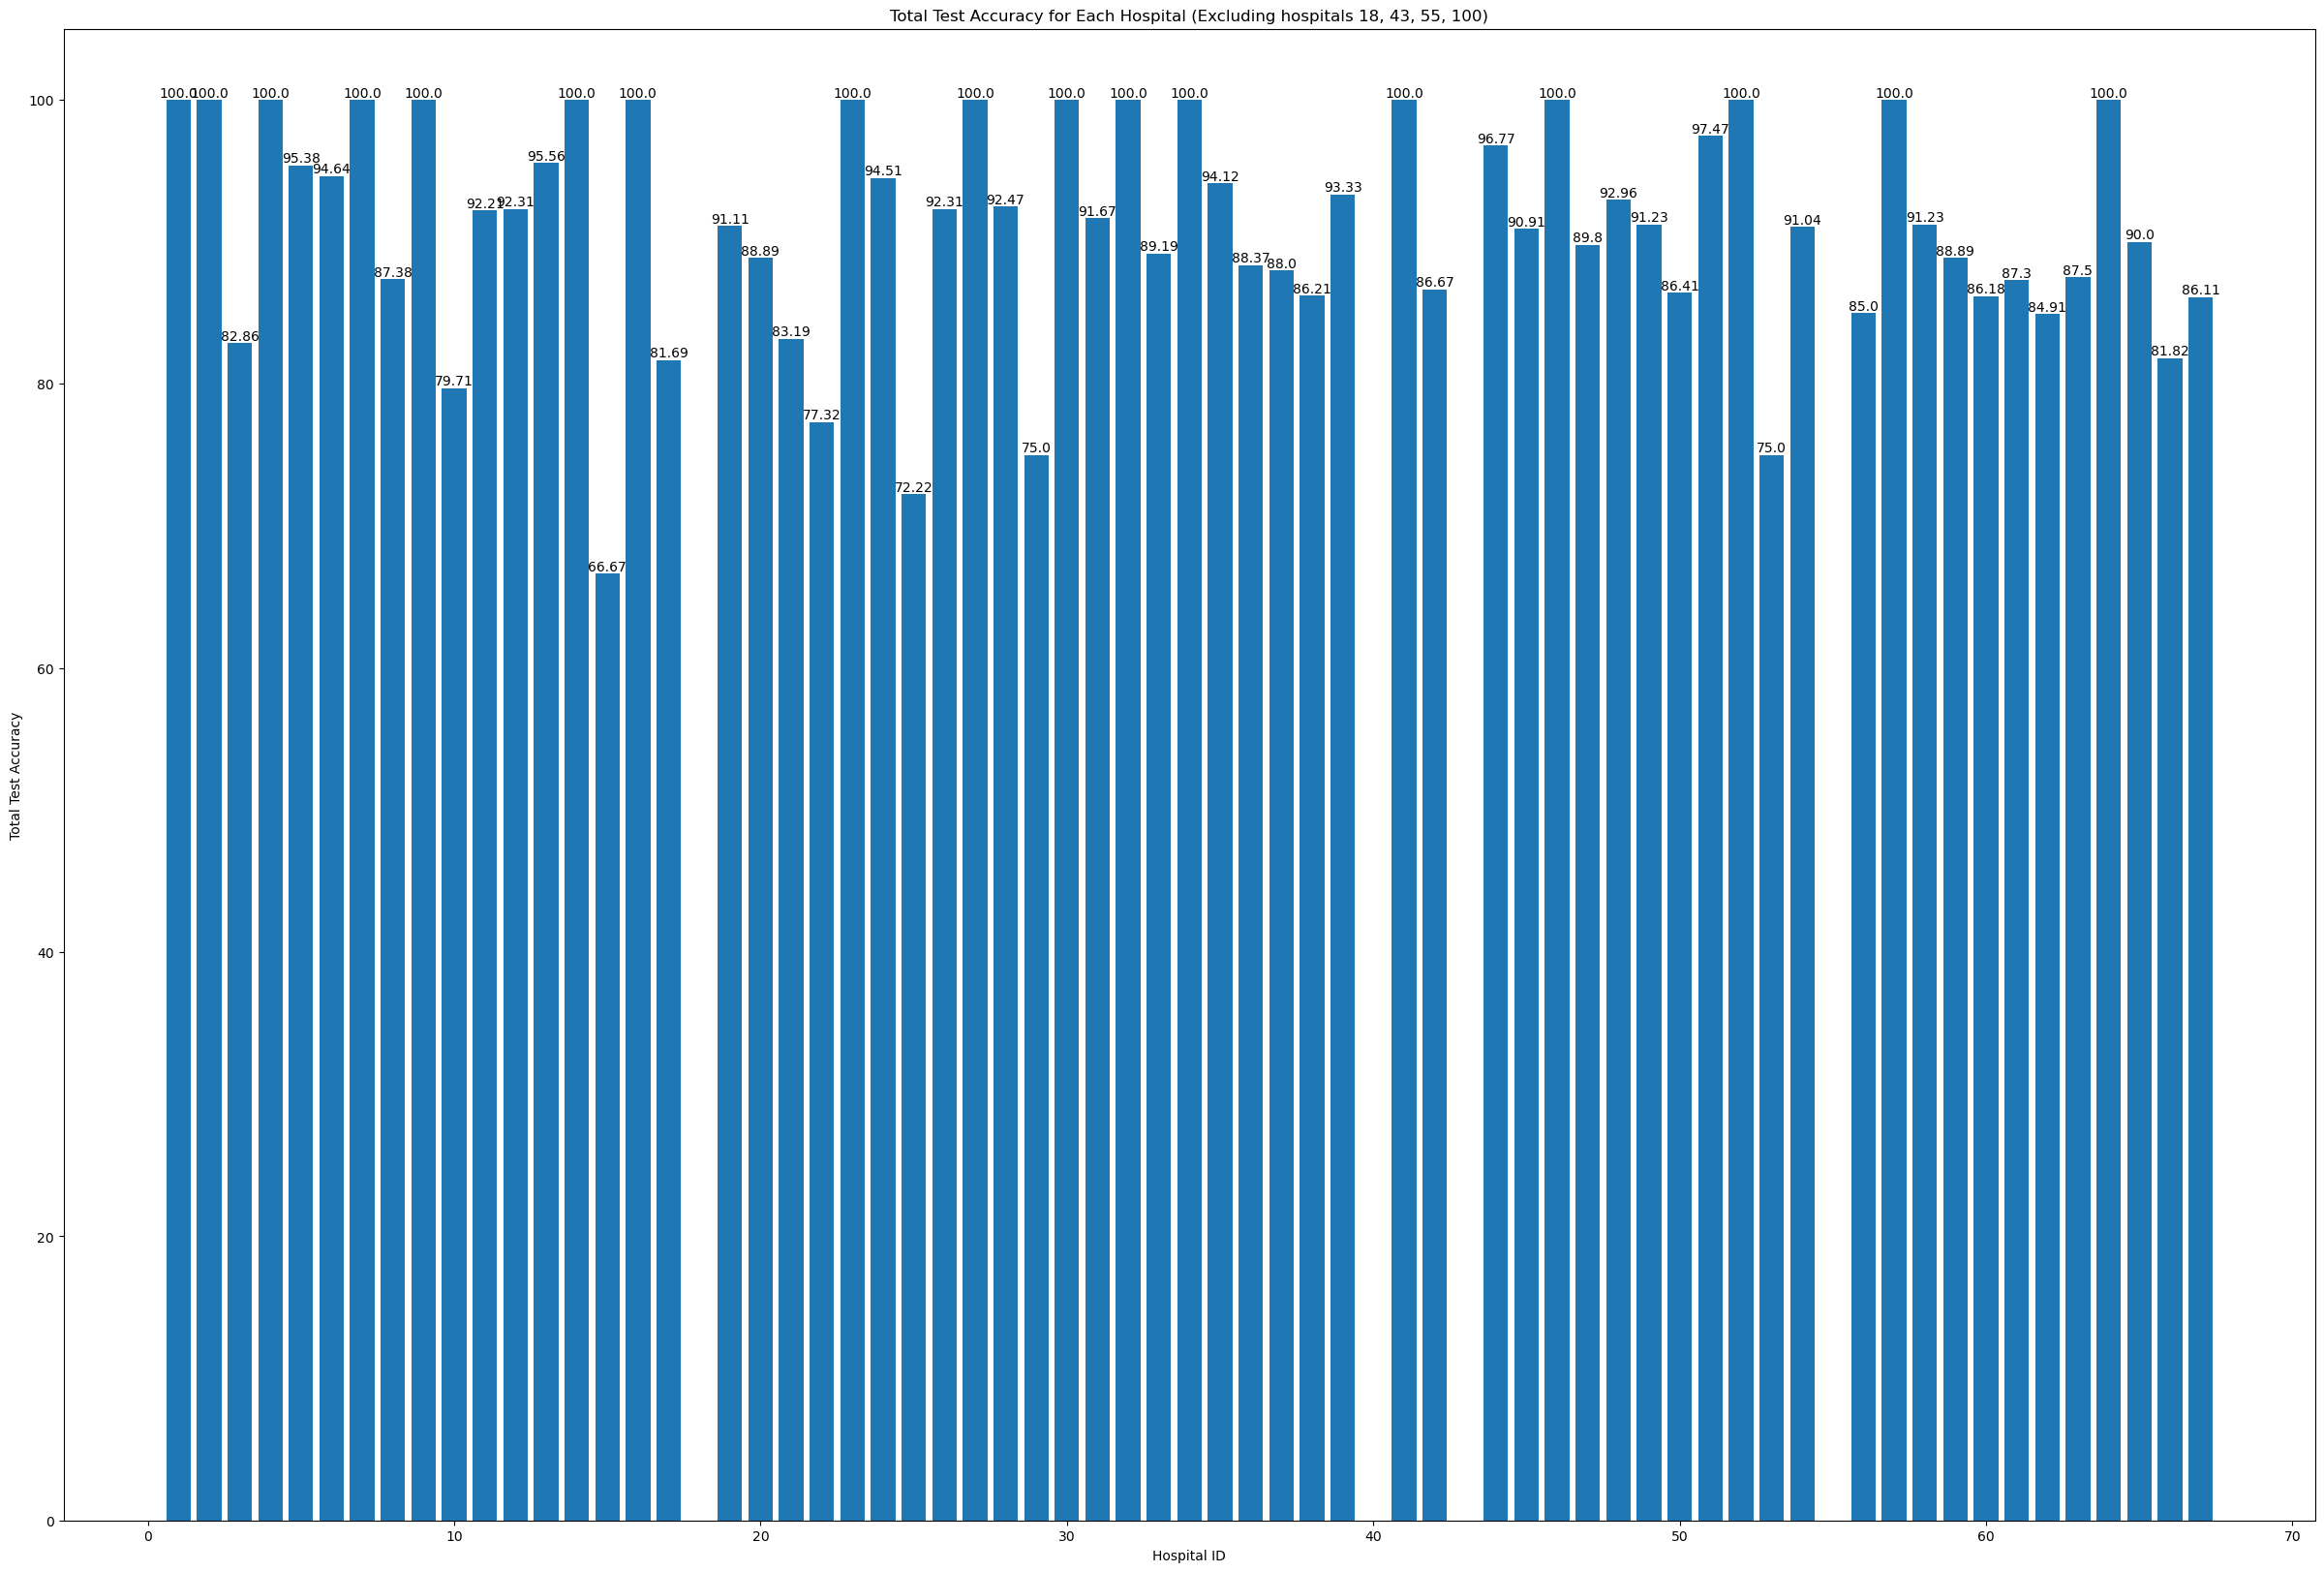

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet152, ResNet152_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        self.features = models.resnet152(weights=ResNet152_Weights.DEFAULT)

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# resnet152_freeze_Adam_200R_1E
global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/020020f4-41a7-4693-9b42-b6414b1010f8/app_server/FL_global_model.pt'
checkpoint = torch.load(global_path, map_location=device)

# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()

# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(30, 20))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()


# DenseNet 161



Performance for Hospital 1:

Test Loss: 0.20350635051727295
Total Test Accuracy: 100.0
Test Accuracy (NFF): 100.0
Test Accuracy (AFF): 0
Confusion Matrix:
 [[23]]
Classification Report:
               precision    recall  f1-score   support

         NFF       1.00      1.00      1.00        23
         AFF       1.00      1.00      1.00         0

   micro avg       1.00      1.00      1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23


Performance for Hospital 2:

Test Loss: 0.7849733829498291
Total Test Accuracy: 33.333333333333336
Test Accuracy (NFF): 0
Test Accuracy (AFF): 33.33333333333333
Confusion Matrix:
 [[0 0]
 [2 1]]
Classification Report:
               precision    recall  f1-score   support

         NFF       0.00      1.00      0.00         0
         AFF       1.00      0.33      0.50         3

    accuracy                           0.33         3
   macro avg       0.50      0.67      0.25    

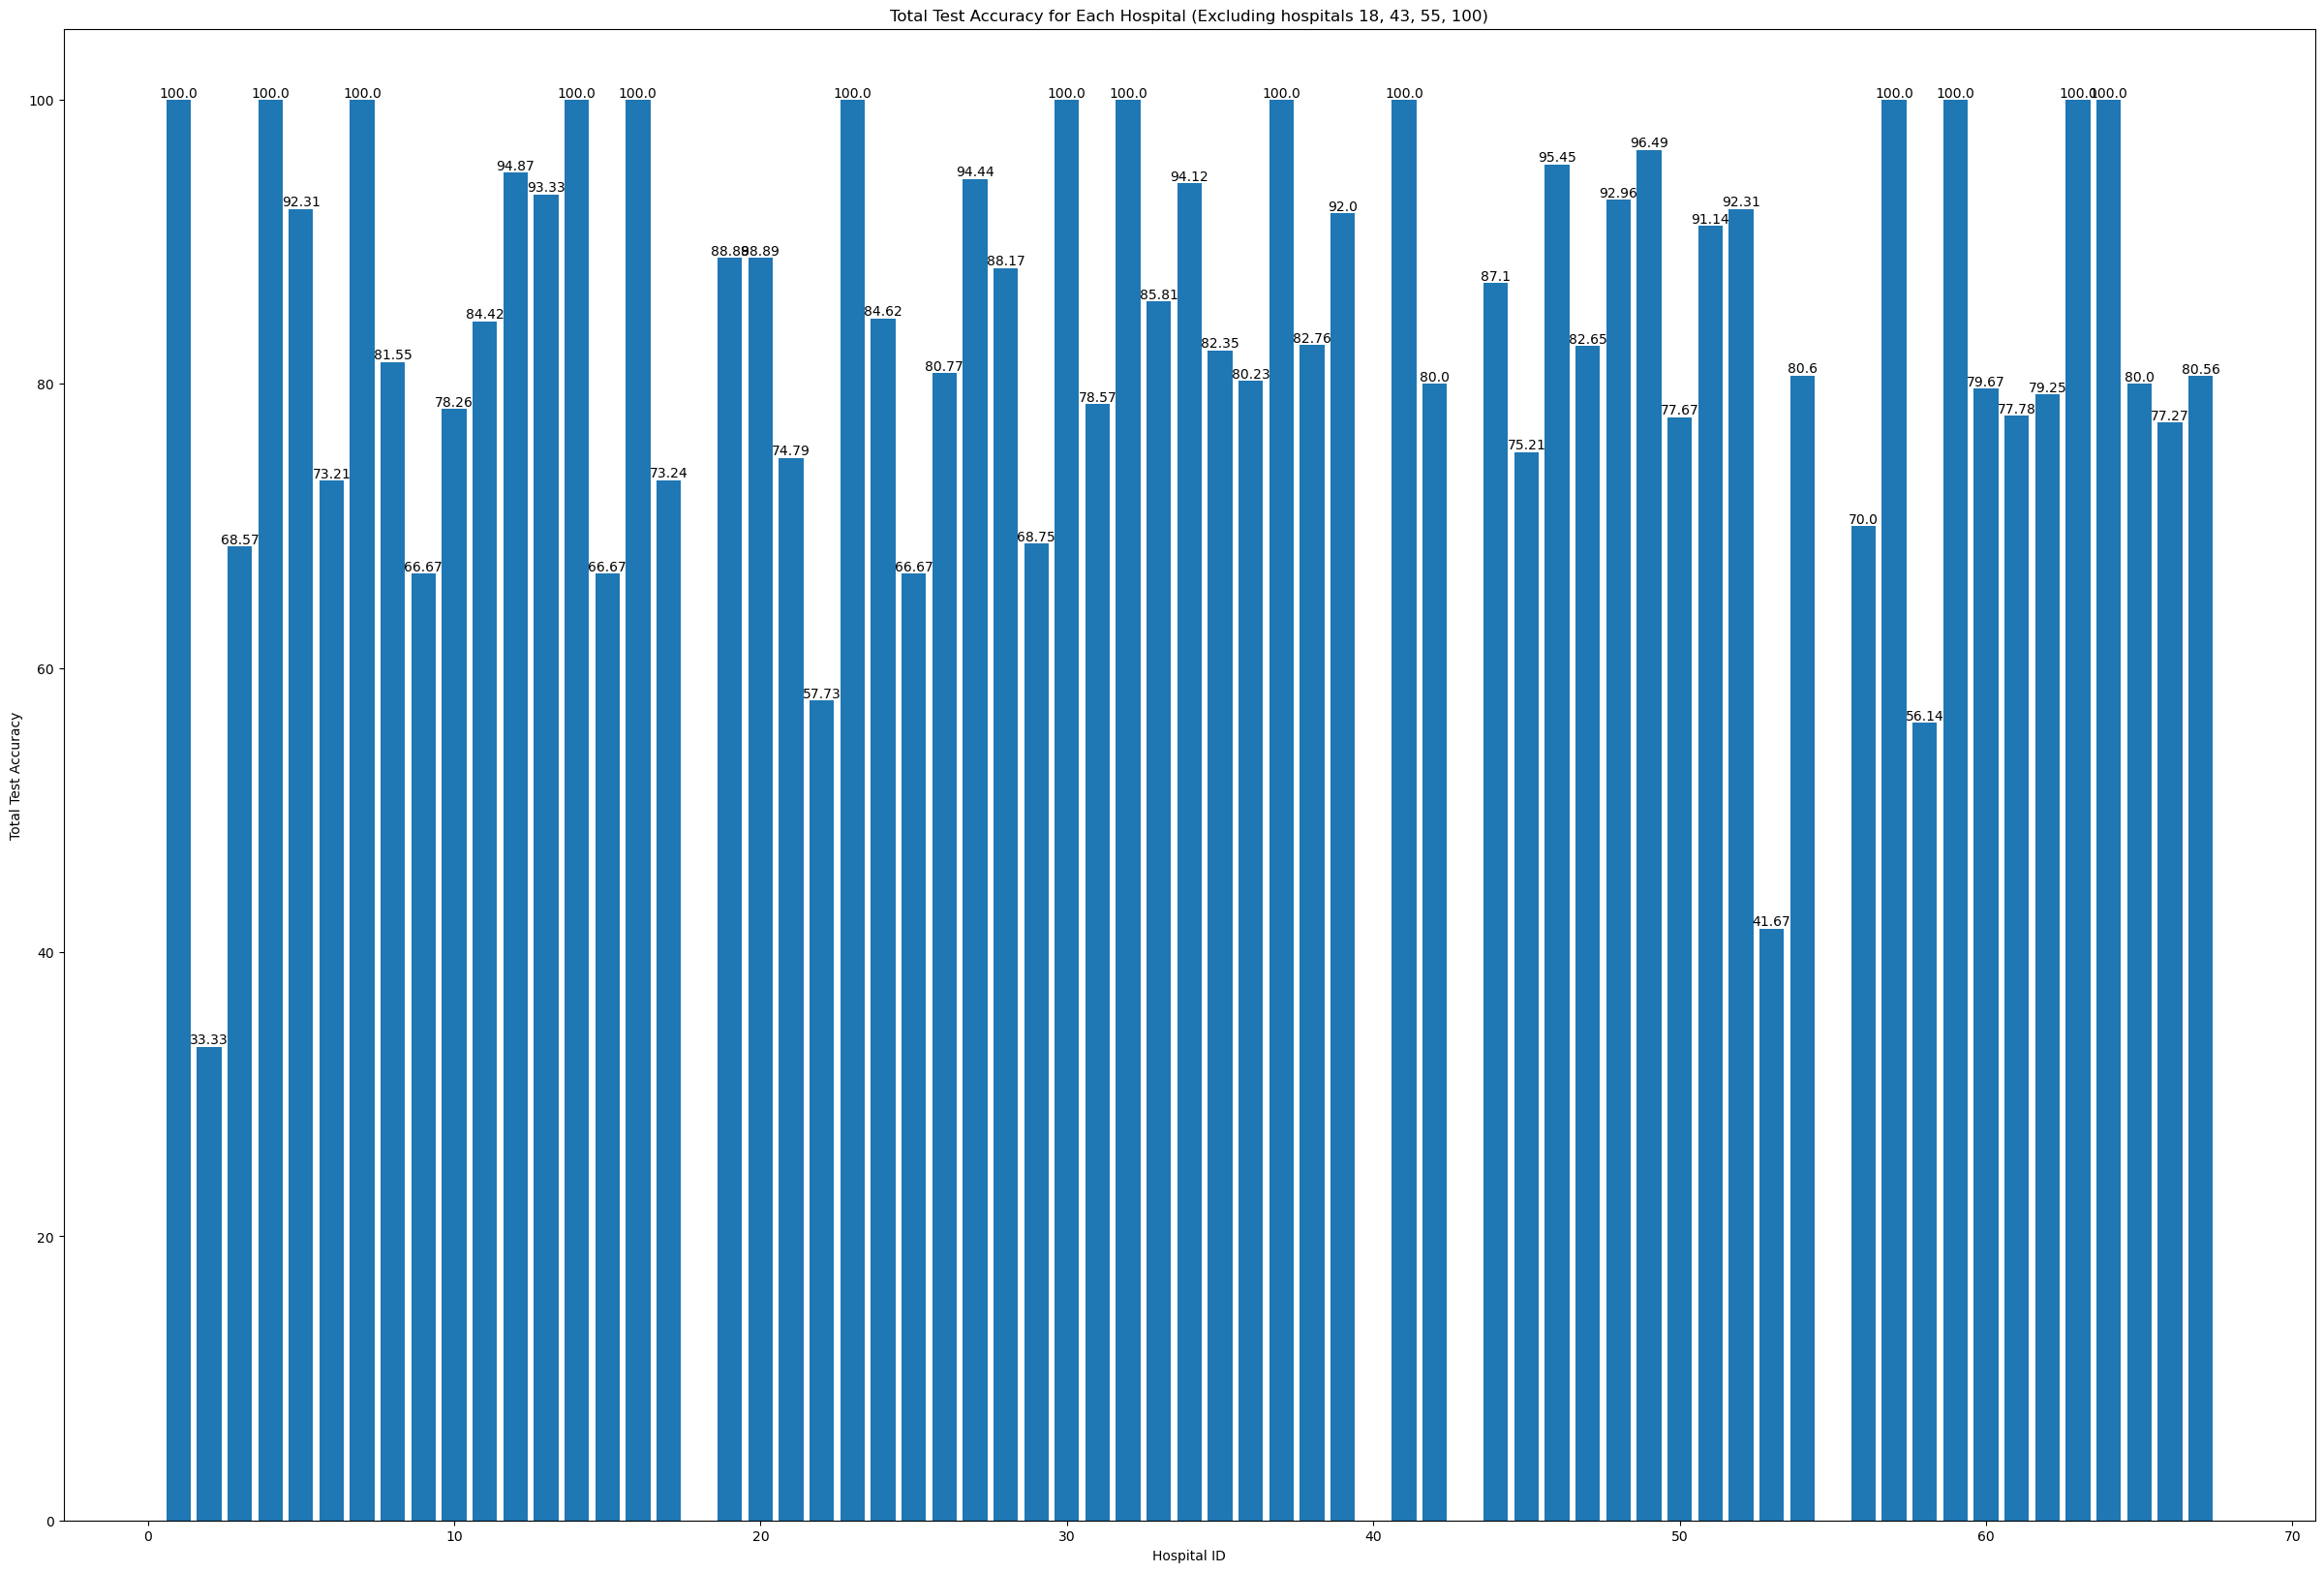

In [27]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import densenet161, DenseNet161_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        self.features = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2208, num_classes)  # DenseNet-161 has 2208 output features

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Global average pooling
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# resnet101_freeze_Adam_200R_1E
global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/ae454dfc-4e4e-4197-bbfd-484aa1a83b87/app_server/FL_global_model.pt'

checkpoint = torch.load(global_path, map_location=device)

# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()


# 加载测试数据集
test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"  # 替换成你的测试数据集的CSV文件路径

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)

# Get unique hospital IDs
unique_hospital_ids = set(test_dataset.hospital_ids)

hospital_accuracies = {}

# Loop over all hospital IDs and print performance metrics
for selected_hospital in unique_hospital_ids:
    # Select data for the current hospital
    filtered_test_data_indices = [idx for idx, hospital_id in enumerate(test_dataset.hospital_ids) if hospital_id == selected_hospital]
    filtered_test_dataset = torch.utils.data.Subset(test_dataset, indices=filtered_test_data_indices)

    # Test the model
    batch_size = 64  # Adjust according to your needs
    metrics = test_model(model, filtered_test_dataset, batch_size)

    # Store Total Test Accuracy for the current hospital
    hospital_accuracies[selected_hospital] = metrics["Total Test Accuracy"]

    # Print or record the model's performance for the current hospital
    print(f"\nPerformance for Hospital {selected_hospital}:\n")
    print("Test Loss:", metrics["Test Loss"])
    print("Total Test Accuracy:", metrics["Total Test Accuracy"])
    print("Test Accuracy (NFF):", metrics["Test Accuracy (NFF)"])
    print("Test Accuracy (AFF):", metrics["Test Accuracy (AFF)"])
    print("Confusion Matrix:\n", metrics["Confusion Matrix"])
    print("Classification Report:\n", metrics["Classification Report"])

# Calculate average performance
average_performance = sum(hospital_accuracies.values()) / len(hospital_accuracies)
print(f"\nAverage Total Test Accuracy: {average_performance}")

# List of hospitals to exclude
exclude_hospitals = {18, 43, 55, 100}

# Filter out excluded hospitals
filtered_accuracies = {hospital: accuracy for hospital, accuracy in hospital_accuracies.items() if hospital not in exclude_hospitals}

# Plotting the bar chart with wider bars and text labels
bar_width = 0.8  # Adjust the width of the bars as needed

# Set the figure size
fig, ax = plt.subplots(figsize=(30, 20))  # Adjust the figsize as needed

# Plot the bar chart
bars = ax.bar(filtered_accuracies.keys(), filtered_accuracies.values(), width=bar_width)

# Add text labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Hospital ID')
plt.ylabel('Total Test Accuracy')
plt.title('Total Test Accuracy for Each Hospital (Excluding hospitals 18, 43, 55, 100)')

# Show the bar chart
plt.show()